In [94]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [95]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using DynamicAxisWarping
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall

In [96]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

PyObject <module 'pandas' from '/Users/boothh/.julia/conda/3/x86_64/lib/python3.10/site-packages/pandas/__init__.py'>

In [97]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [98]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

In [99]:
data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_beta_1.jld2"));

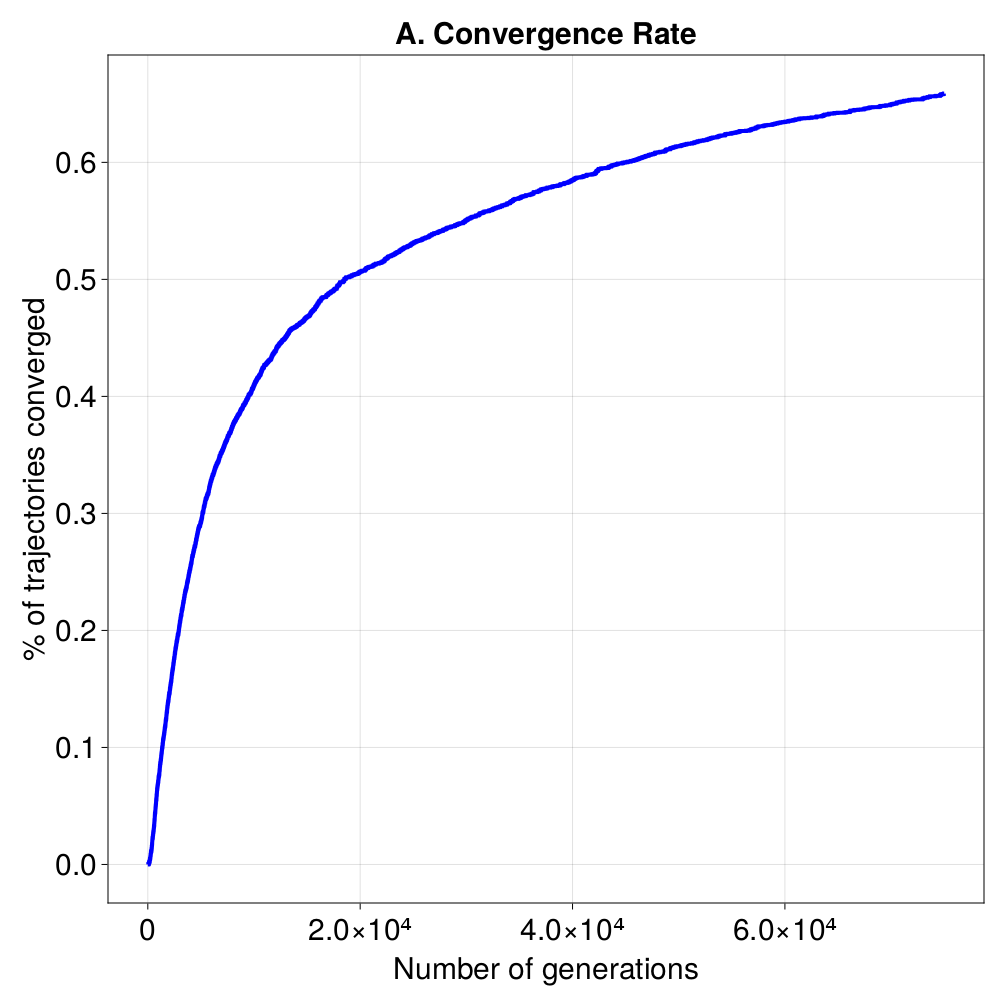

In [100]:
conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [101]:
fundamental_networks_dyn_cell = pmap(nt->get_rel_dyn_vector(nt[1],nt[2],n_steps,save_id),zip(fundamental_networks,fundamental_networks_t2s));
fundamental_networks_dyn_av = pmap(nt->get_av_dyn_vector(nt[1],nt[2],n_steps,n_segments),zip(fundamental_networks,fundamental_networks_t2s));

fund_X_cell = reduce(hcat,fundamental_networks_dyn_cell)
fund_X_av = reduce(hcat,fundamental_networks_dyn_av);

In [102]:
sim_m = copy(data["fund_dmat_cell"])
conv = copy(data["converged"]);

n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],data["geno_traj"]);

mind_class =  map(x->fundamental_labels[x[2]],argmin(sim_m,dims =2)) 

incl_top = reduce(hcat,map(en->[test_inclusion(en,vec(network_topology_dict[n])) for n in fundamental_topologies],end_networks)) |> transpose |> collect;

dyn_top_mind = zeros(Int,length(end_networks),length(fundamental_topologies))

top_assignment_mind = map(x->fund_top_ndict[x],mind_class)

for (net,t) in enumerate(top_assignment_mind)
    dyn_top_mind[net,t] = 1
end

########

class_labels = map(x->fund_top_dict[x],determine_class(incl_top,dyn_top_mind))[conv];


In [103]:
countmap(class_labels)

Dict{String, Int64} with 5 entries:
  "bistable"      => 56
  "feed_forward"  => 5
  "classical"     => 1417
  "mutual_inh"    => 2
  "No assignment" => 1814

In [104]:
class_labels_u = unique(class_labels)

5-element Vector{String}:
 "No assignment"
 "classical"
 "bistable"
 "feed_forward"
 "mutual_inh"

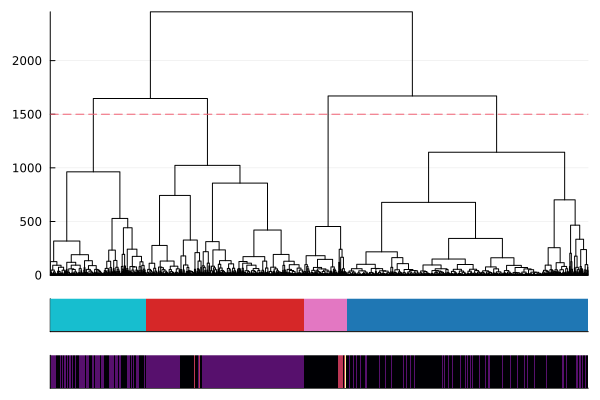

In [191]:
cu_thresh =  1500

hc1 = hclust(dmat_av[conv,conv],linkage = :ward)

clust_labels = cutree(hc1,h = cu_thresh)

p1 = hline!(StatsPlots.plot(hc1,xticks = false,label = nothing),[cu_thresh],linestyle = :dash)
p2 = StatsPlots.heatmap(reshape(clust_labels[hc1.order],(1,n_traj)),colorbar=false,yticks = false,xticks = false,colormap = cgrad(:tab10,categorical = true))
p3 = StatsPlots.heatmap(reshape(class_labels[hc1.order],(1,n_traj)),colorbar=false,yticks = false,xticks = false, color_map = cp)

# h2 = StatsPlots.scatter([0,0], [0,1], zcolor=[1,5],
#              xlims=(1,1.1), label="",c=palette([:red,:green,:yellow,:blue,:pink]),colorbar_title="Topology", framestyle=:none)

l = @layout [StatsPlots.grid(3, 1,heights=[0.8,0.1,0.1])]

p_all = StatsPlots.plot(p1, p2,p3, layout=l)

# StatsPlots.savefig(p_all,plotsdirx("MSelection","Clust1Select.png"))

p_all

In [154]:
color_name = ["purple","red","green","yellow","blue","pink"]

color_dict = Dict(i=>color_name[fund_top_ndict[i]+1] for i in class_labels_u)

Dict{String, String} with 5 entries:
  "bistable"      => "blue"
  "feed_forward"  => "red"
  "classical"     => "pink"
  "mutual_inh"    => "green"
  "No assignment" => "purple"

In [155]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj = map(t->map(x->x[2]+x[1],unique(t)),fitness_traj_b);

# fitness_traj_u = map(t->map(x->x[2]+x[1],t),fitness_traj_b);

geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

In [156]:
function get_mutant_n_dist(g_traj)
    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    return sum(g_traj_diff .!= 0.,dims = 1)[1,:]
end

function get_mutant_dist(g_traj)
    g_traj_diff = (g_traj[:,2:end] .- g_traj[:,1:end-1]) ./ map(x-> x == 0 ? 1. : x, g_traj[:,1:end-1])
    
    return [filter(x->x .!= 0.,v) for v in eachcol(g_traj_diff)]
end

function get_fitness_delta(f_traj)
    f_traj_diff = f_traj[2:end] .- f_traj[1:end-1]
    return f_traj_diff
end

function get_mutation_id(g_traj)

    g_traj_diff = g_traj[:,2:end] .- g_traj[:,1:end-1]
    mut_id = [findall(x-> x .!= 0, y) for y in eachcol(g_traj_diff)]

    return mut_id
end


weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [157]:
mut_types = data["mut_type"][conv];
mut_choices = data["mut_choices"][conv]

dmc_re = map(mct->map(mc->map(x->ci_indices_dict[x],mc),mct),mut_choices)

dmc_re_sp = map(mct->map(x->sortperm(x),mct),dmc_re)

mut_choices_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(dmc_re,dmc_re_sp)];

mut_types_ro = [[v[o] for (v,o) in zip(vi,vo)] for (vi,vo) in zip(mut_types,dmc_re_sp)];

In [158]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),fitness_traj)))

n_bin = 10

hist_edges = zeros(n_bin+1)

hist_edges[1] = initial_fitness

hist_edges[2:n_bin] .= LinRange(initial_fitness+eps(),0.9,n_bin-1) |> collect

hist_edges[n_bin+1] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),unique(traj)),fitness_traj);

In [159]:
# clust_labels = copy(class_labels);

In [160]:
mut_id = map(x->get_mutation_id(unique(x,dims = 2)),geno_traj);

mut_id_labels = map(v->map(x->weight_names[x],v),mut_id);

mut_id_labels = map(v->map(x->(n_mut=length(x),mut_id_name=join(map(i->weight_names[i],x),"|"),mut_id=x),v),mut_id);

mut_dist = map(x->get_mutant_dist(unique(x,dims = 2)),geno_traj);

fitness_delta = map(x->get_fitness_delta(unique(x)),fitness_traj);

actual_fitness = map(x->x[1:end-1],fitness_traj);

actual_networks = map(x->[x[:,j] for j in 1:size(x[:,1:end-1],2)],geno_traj);

actual_mutant = map(x->[j for j in 1:size(x[:,1:end-1],2)],geno_traj);

mut_id_label_type = [[(mut_type=mut_typ,midl...) for (mut_typ,midl) in zip(mut_types_ro[i],mut_id_labels[i])] for i in 1:length(mut_id_labels)];

mut_id_size_label = [[(mut_size=mut_size,midl...) for (mut_size,midl) in zip(mut_dist[i],mut_id_label_type[i])] for i in 1:length(mut_id_label_type)];

mut_id_size_label_am = [[(mut_number=mut_number,midl...) for (mut_number,midl) in zip(actual_mutant[i],mut_id_size_label[i])] for i in 1:length(mut_id_size_label)];

mut_id_size_label_an = [[(existing_network=network,midl...) for (network,midl) in zip(actual_networks[i],mut_id_size_label_am[i])] for i in 1:length(mut_id_size_label_am)];

mut_id_size_label_af = [[(existing_fitness=fitness,midl...) for (fitness,midl) in zip(actual_fitness[i],mut_id_size_label_an[i])] for i in 1:length(mut_id_size_label_an)];

mut_id_size_label_fb = [[(fitness_bin=fb,midl...) for (fb,midl) in zip(fitness_routes[i],mut_id_size_label_af[i])] for i in 1:length(mut_id_size_label_af)];

mut_id_size_label_fb_ft = [[(fitness_delta=fd,midl...) for (fd,midl) in zip(fitness_delta[i],mut_id_size_label_fb[i])] for i in 1:length(mut_id_size_label_fb)];

mut_id_size_label_fb_cc = [[(cluster_id=clust_labels[i],midl...) for midl in mut_id_size_label_fb_ft[i]] for i in 1:length(mut_id_size_label_fb_ft)];

mut_info = [[(traj_id=i,midl...) for midl in mut_id_size_label_fb_cc[i]] for i in 1:length(mut_id_size_label_fb_cc)];

all_mut_info = reduce(vcat,mut_info);

In [161]:
function condition_data(return_var,condition_var,condition_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

function condition_data_return_tuples(condition_var,condition_values,data)

    return filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]),data)
end

function condition_data_incl(return_var,condition_var,condition_values,incl_var,incl_values,data)

    results = [map(x->x[rv],filter(x->all([x[var] == value for (var,value) in zip(condition_var,condition_values)]) & all([value ∈ x[var] for (var,value) in zip(incl_var,incl_values)]),data)) for rv in return_var]

    return NamedTuple{return_var}(results)
end

condition_data_incl (generic function with 1 method)

In [162]:
r1 = condition_data((:traj_id,:existing_fitness,:fitness_delta,:existing_network,:mut_size,:mut_id),[:traj_id,:mut_number],[1,1],all_mut_info);
r2 = condition_data((:traj_id,:existing_fitness,:fitness_delta,:existing_network,:mut_size,:mut_id),[:traj_id,:mut_number],[1,2],all_mut_info);


In [163]:
r1

(traj_id = [1], existing_fitness = [-0.9985165945734575], fitness_delta = [0.41804851644510244], existing_network = [[0.0, 0.0, -0.21577059555519695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2490335893436255, 0.0, 0.0]], mut_size = [[0.8486741279718597]], mut_id = [[9]])

In [164]:
r2

(traj_id = [1], existing_fitness = [-0.5804680781283551], fitness_delta = [0.05920974829236725], existing_network = [[0.0, 0.0, -0.21577059555519695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8486741279718597, 1.2490335893436255, 0.0, 0.0]], mut_size = [[-0.10901435919976823]], mut_id = [[3]])

In [165]:
min_start_g = minimum(abs.(filter(x->x!=0,geno_traj[1][:,1])))

0.21577059555519695

In [166]:
r = condition_data((:mut_id_name,:mut_size,:mut_type,:cluster_id),[:fitness_bin,:n_mut],[1,1],all_mut_info);

# mut_id = map(x->weight_names[x],reduce(vcat,r[:mut_id]))

mut_id = reduce(vcat,r[:mut_id_name])

mut_sign = [i > 0 ? "-act" : "-inh" for i in sign.(reduce(vcat,r[:mut_size]))]

# mut_sign = [i < min_start_g ? "-small" : "-large" for i in abs.(reduce(vcat,r[:mut_size]))]

# mut_id = mut_id .* mut_sign

clust_id =r[:cluster_id]

d = pd.DataFrame(Dict("Weight" => mut_id, "Topology" => clust_id))


,Topology,Weight
0,1,C=>C
1,2,C=>C
2,3,C=>C
3,2,C=>C
4,2,C=>C
...,...,...
1986,1,C=>C
1987,2,C=>C
1988,4,B=>C
1989,2,B=>C


In [167]:
d_all = pd.DataFrame(Dict("Weight" => ["All" for _ in mut_id], "Topology" => clust_id))

d_en = pd.concat([d,d_all])

,Topology,Weight
0,1,C=>C
1,2,C=>C
2,3,C=>C
3,2,C=>C
4,2,C=>C
...,...,...
1986,1,All
1987,2,All
1988,4,All
1989,2,All


In [184]:
# props = key -> Dict("color" => color_dict[key[2]])
labelizer = key -> ""

fig = statmod.mosaic(d_en,["Weight","Topology"],labelizer = labelizer,label_rotation = 90)

plt.show()

In [190]:
cgrad(:tab20,categorical = true)[4]

In [186]:
clust_labels

3294-element Vector{Int64}:
 1
 2
 1
 3
 2
 2
 1
 2
 1
 1
 ⋮
 1
 4
 2
 2
 4
 4
 2
 4
 4

In [169]:
dchi = pd.crosstab(d["Weight"],d["Topology"]).values

ChisqTest(dchi)

Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.154325, 0.302229, 0.100337, 0.196499, 0.0286919, 0.0561901, 0.0546674, 0.10706]
    point estimate:          [0.0497238, 0.406831, 0.17328, 0.123556, 0.0698142, 0.0150678, 0.0452034, 0.116524]
    95% confidence interval: [(0.02762, 0.07206), (0.3847, 0.4292), (0.1512, 0.1956), (0.1015, 0.1459), (0.04771, 0.09215), (0.0, 0.0374), (0.0231, 0.06754), (0.09442, 0.1389)]

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-99

Details:
    Sample size:        1991
    statistic:          554.9207672951192
    degrees of freedom: 3
    residuals:          [-11.881, 8.48993, 10.2752, -7.34242, 10.8326, -7.74075, -1.80612, 1.29061]
    std. residuals:     [-19.8086, 19.8086, 15.0605, -15.0605, 13.9179, -13.9179, -2.42455, 2.42455]
